## Mitral Regurgitation LFs
Notebook to derive LFs for mitral regurgitation <br>
Selecting some canonical examples of MR and nonMR <br>
Narrowing range of frames to <5 <br>
To display: smaller mask, union, intersection of masks, difference between frames 

In [1]:
#%matplotlib inline
%matplotlib notebook
import cv2 
import imageio
import pickle
import pydicom
import random
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from scipy.sparse import csr_matrix

import sys
sys.path.append('../metal')

In [2]:
def OCIndex2Label(index_open, index_close):
    """
    Converts from open and close index to frame-wise labels   
    
    Params
    -------
    index_open: int
    index_close: int
    
    Return
    -------
    frame_labels: numpy array of shape (1,50)
    
    """
    index_open = int(index_open)
    index_close = int(index_close)
    
    frame_labels = np.zeros([1,50]);
    if(index_close >= index_open):
        frame_labels[0,index_open:index_close] = 1
    else:
        frame_labels[0,index_open:50] = 1
        frame_labels[0,0:index_close] = 1
        
    return frame_labels   

In [3]:
def findAreaLabel(mask):
    '''
    function to find labels based on area of left atrium
    
    Input
    -----
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    area_la = np.sum(np.sum(mask==1.0,axis=2),axis=1) # area of left atrium
    
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(area_la)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(area_la)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-3)%50
    index_high = (index_close+2)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [4]:
def findPerimeterLabel(mask_original):
    '''
    function to find labels based on perimeter of left atrium
    
    Input
    -----
    mask_original: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    
    # finding perimeter of left atrium 
    mask = np.copy(mask_original)
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    perimeter = np.zeros((50,1))
    for frame in range(50):
        regions = regionprops(mask[frame])
        perimeter[frame] = regions[0].perimeter
        
    # mitral valve opens - when perimeter is largest
    index_open = np.argmax(perimeter)

    # mitral valve closes - when perimeter is smallest
    index_close = np.argmin(perimeter)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-3)%50
    index_high = (index_close+2)%50
        
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [5]:
def findIntensityLabel(data, mask_original):
    '''
    function to define labels based on intensity within left atrium
    
    Input
    -----
    data: float (50,208,174)
    mask_original: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    # avg intensity within segment
    #mask = [mask_original == 1.0] 
    mask = np.copy(mask_original)
    mask[mask!=1.0] = 0.0
    mask = mask.astype(float)
    area_intensity = np.mean(np.mean(np.multiply(mask,data),axis=2),axis=1)
        
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(area_intensity)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(area_intensity)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
        
    return label

In [6]:
def findIntensityLabel2(data, mask_original):
    '''
    function to define labels based on intensity along perimeter of left atrium
    
    Input
    -----
    data: float (50,208,174)
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    # avg intensity within segment
    #mask = [mask_original == 1.0] 
    mask = np.copy(mask_original)
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    boundary = find_boundaries(mask,mode='outer')
    intensity = np.mean(np.mean(np.multiply(boundary,data),axis=2),axis=1)
        
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(intensity)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(intensity)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [7]:
def findLabelPrior():
    index_open = 20
    index_close = 1
    
    label = OCIndex2Label(index_open,index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
        
    return label

In [8]:
# define 80% coverage labelling functions
#import import_ipynb
#import labelling_functions_3

def findOCLFs(data,mask):
    '''
    Function computes the LFs for the given data
    Saves the numpy array for each individual PID in the folder specified
    '''
    L = np.zeros((50,5))
    L[:,0] = np.squeeze(np.transpose(findAreaLabel(mask)))
    L[:,1] = np.squeeze(np.transpose(findPerimeterLabel(mask)))
    L[:,2] = np.squeeze(np.transpose(findIntensityLabel(data,mask)))
    L[:,3] = np.squeeze(np.transpose(findIntensityLabel2(data,mask)))
    L[:,4] = np.squeeze(np.transpose(findLabelPrior()))
    #L = L + 1
    
    return L

In [9]:
# call labelling functions, define majority vote classifier 
# return prediction probabilities
import sys
sys.path.append('../heart_mri/metal')
from metal.label_model.baselines import MajorityLabelVoter

def findMajorityPred(data,mask):
    L = findOCLFs(data,mask)
    
    mv = MajorityLabelVoter(seed=123)
    prob = mv.predict_proba(L)
    
    return prob

In [10]:
# define which frames are picked using prediction probabilities 
def findClosedFrames(data, mask, num_frames = 5):
    prob = findMajorityPred(data,mask)
    
    prob = prob[:,0]
    closed_frames = [i for i,x in enumerate(prob) if x == 1.0]
    
    # returning the first 10 closed frames
    if len(closed_frames) > num_frames:
        closed_frames = closed_frames[:num_frames]
        
    return closed_frames

# can try to import functions from a regular python file instead of copy-pasting 

In [11]:
# given centroids and mask for a single frame - 
# defines a half plane based on centroids
# multiplies with mask 
def findSubregionFrame(c_left,c_right,mask):
    '''
    c_left: (x1, y1) float
    c_right: (x2, y2) float
    mask: (208, 180) float
    '''
    x1 = c_left[0]
    y1 = c_left[1]
    
    x2 = c_right[0]
    y2 = c_right[1]
    
    slope = ( x2 - x1 ) / ( y2 - y1 ) # flipped because of row/col convention in indexing
    new_mask = np.zeros(mask.shape)
    
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if(x > slope*(y-y1) + x1):
                new_mask[x,y] = 1
                
    new_mask = new_mask*mask
    new_mask[new_mask!=1.0] = 0
    
    return new_mask

In [12]:
def findSubregion(mask_original):
    '''
    Input
    ------
    mask_original: (50, 208, 180) float
    
    
    Output
    ------
    new_mask: (50, 208, 180) float
    mask defining a smaller region
    '''
    
    # finding left and right atrium masks
    mask_left = np.copy(mask_original)
    mask_left[mask_left!=1.0] = 0.0
    mask_left = mask_left.astype(int)

    mask_right = np.copy(mask_original)
    mask_right[mask_right!=2.0] = 0.0
    mask_right = mask_right.astype(int)
    
    # finding centroids
    centroid_left = np.zeros((50,2))
    centroid_right = np.zeros((50,2))
    for frame in range(mask_original.shape[0]):
        left_region = regionprops(mask_left[frame])
        centroid_left[frame] = left_region[0].centroid

        right_region = regionprops(mask_right[frame])
        centroid_right[frame] = right_region[0].centroid
        
    # finding subregions
    new_mask = np.zeros(mask_original.shape)
    for frame in range(mask_original.shape[0]):
        new_mask[frame,:,:] = findSubregionFrame(centroid_left[frame,:],centroid_right[frame,:],
                         mask_original[frame,:,:])
    
    return new_mask

In [13]:
# selecting PIDs for analysis
# MR PIDs from train set - can be viewed on DICOM viewer
# 3081388, 3340464, 2002329
MR_PIDs = ['3081388', '3340464', '2002329']

# Other MR PIDs in DICOM viewer
# 1298891, 4730312, 3749507 - faint
# 3731562, 4348411 - left ventricle enlarged 
# 4585988 - strange looking heart

# non MR PIDs from train set 
# 2340116, 2705213, 5763523
nonMR_PIDs = ['2340116', '2705213', '5763523']


In [14]:
# loading data
data_path = '../data/mr/train/'
labels = pd.read_csv(data_path+'labels.csv')

data = {}
mask = {} 
Y = {}
for PID in MR_PIDs:
    print(PID)
    data[PID] = np.load(data_path+'la_4ch/'+str(PID)+'.npy')
    mask[PID] = np.load(data_path+'la_4ch_mask/'+str(PID)+'.npy')
    Y[PID] = 1    
    
for PID in nonMR_PIDs:
    print(PID)
    data[PID] = np.load(data_path+'la_4ch/'+str(PID)+'.npy')
    mask[PID] = np.load(data_path+'la_4ch_mask/'+str(PID)+'.npy')
    Y[PID] = 0   

3081388
3340464
2002329
2340116
2705213
5763523


3081388


<IPython.core.display.Javascript object>


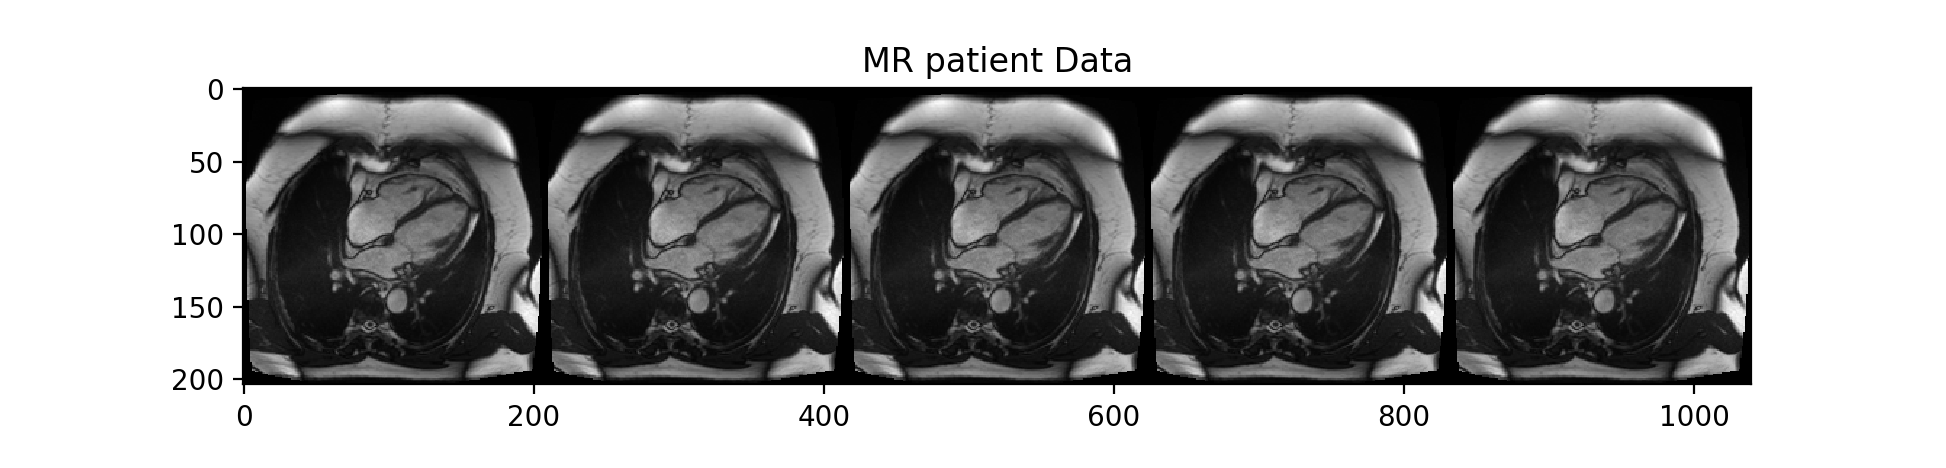

<IPython.core.display.Javascript object>


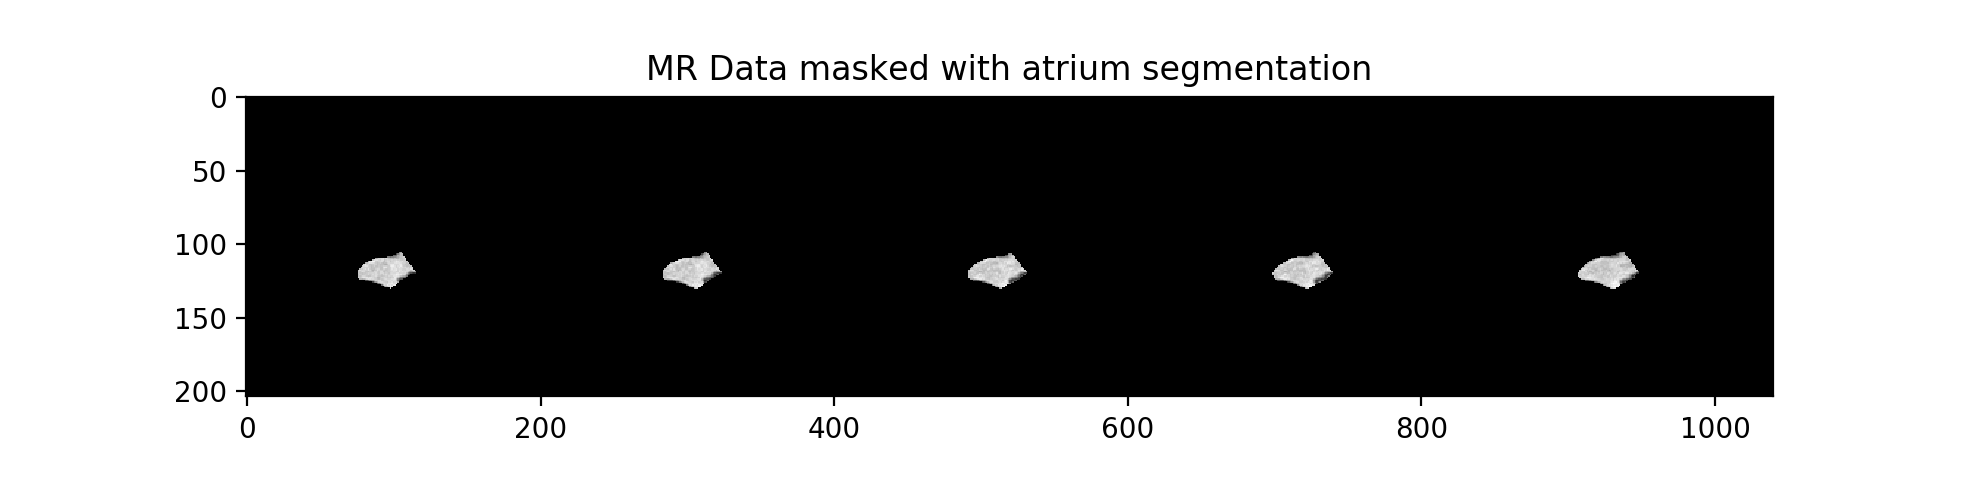

<IPython.core.display.Javascript object>


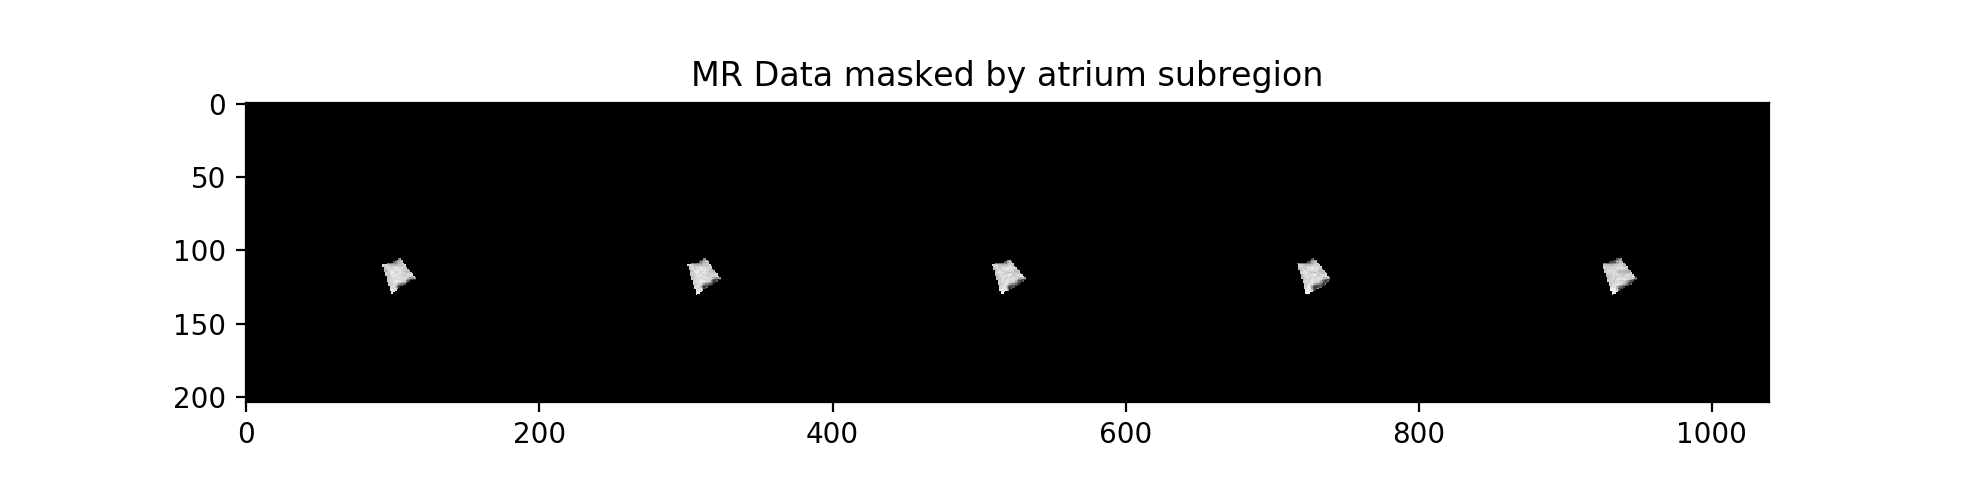

In [15]:
# narrowing down closed frames to 5
PID1 = MR_PIDs[0]
print(PID1)

num_frames = 5
frames = findClosedFrames(data[PID1], mask[PID1],num_frames)
data1 = data[PID1]
data1 = data1[frames,:,:]

plt.figure()
plt.title('MR patient Data')
plt.imshow(np.transpose(np.concatenate(data1, axis=0)), cmap = 'gray')

# plotting masked data
og_mask1 = mask[PID1]
og_mask1 = og_mask1[frames,:,:]
og_mask1[og_mask1!=1.0] = 0.0
og_masked_data1 = np.multiply(data1,og_mask1)

plt.figure()
plt.title('MR Data masked with atrium segmentation')
plt.imshow(np.transpose(np.concatenate(og_masked_data1, axis=0)), cmap = 'gray')


# plotting the image of the subregion for the PIDs
mask1 = mask[PID1]
mask1 = mask1[frames,:,:]
subregion_mask1 = findSubregion(mask1)

subregion_masked_data1 = np.multiply(data1,subregion_mask1)

plt.figure()
plt.title('MR Data masked by atrium subregion')
plt.imshow(np.transpose(np.concatenate(subregion_masked_data1, axis=0)), cmap = 'gray')

<IPython.core.display.Javascript object>


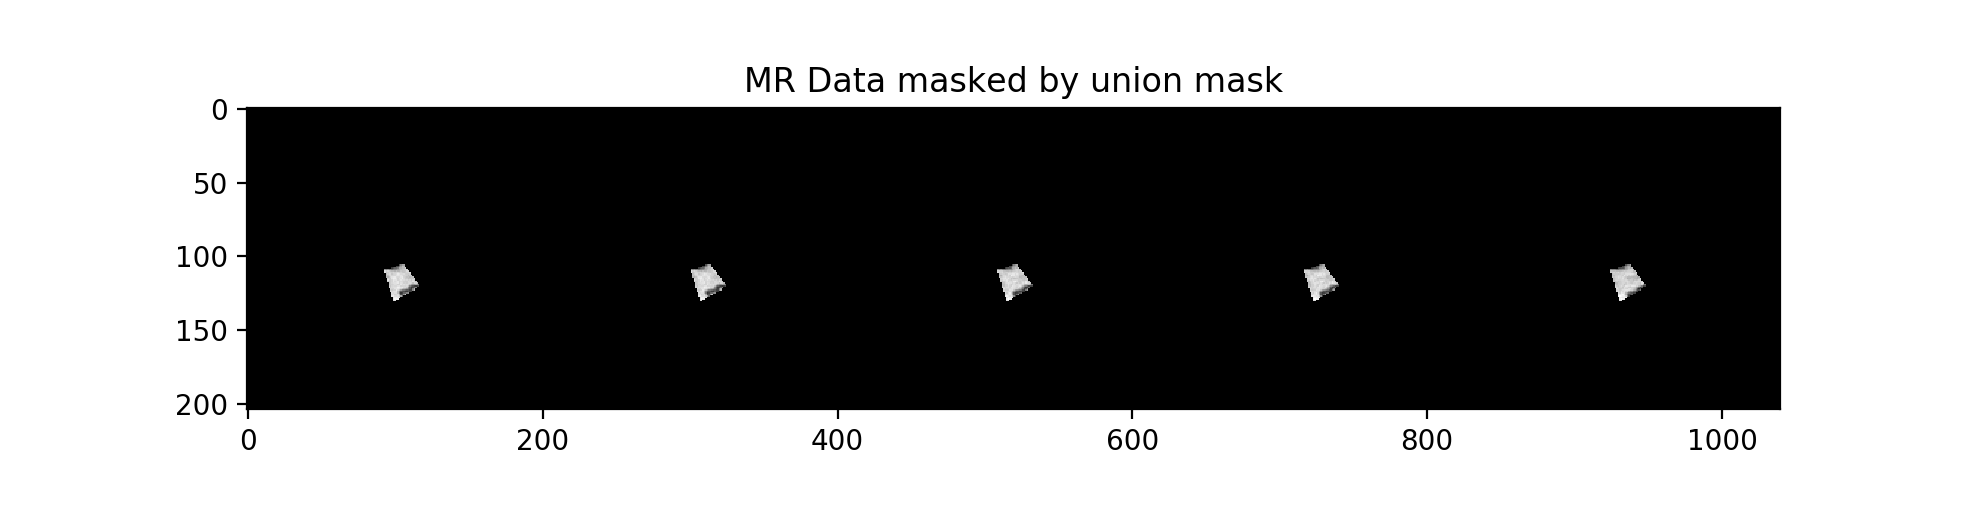

<IPython.core.display.Javascript object>


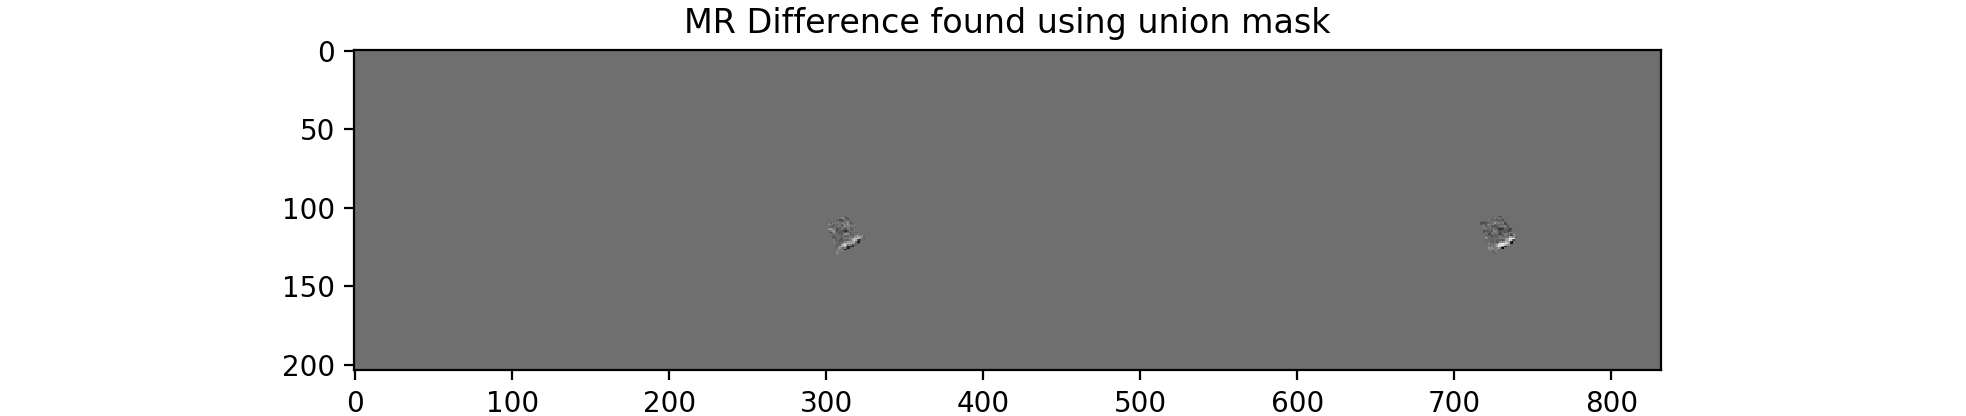

<IPython.core.display.Javascript object>


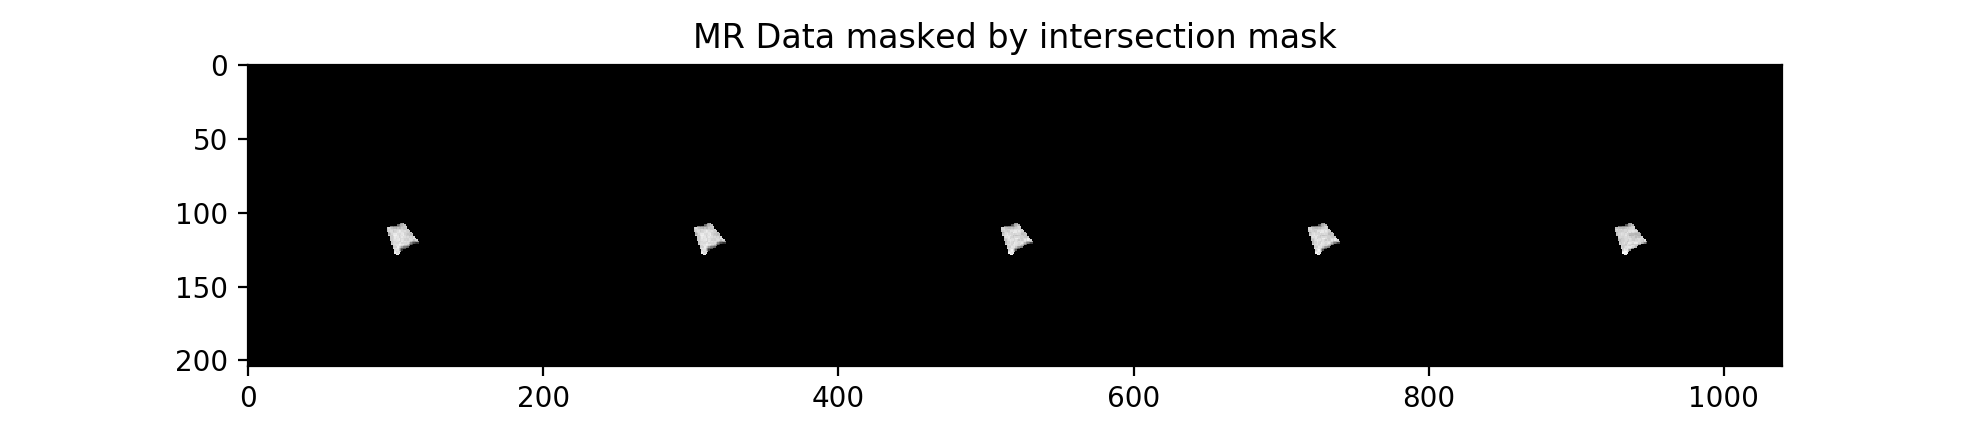

<IPython.core.display.Javascript object>


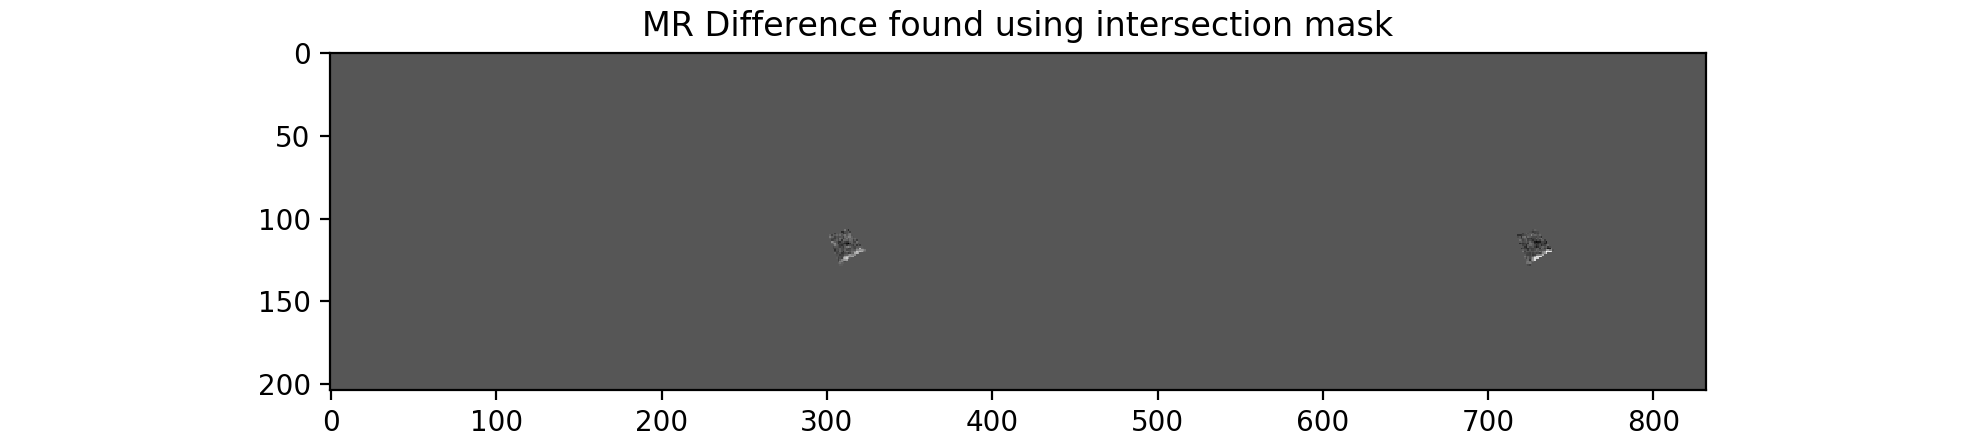

In [16]:
# subregion using union mask
union_mask1 = np.sum(subregion_mask1,axis=0)
union_mask1[union_mask1>1.0] = 1.0
union_mask1 = np.tile(union_mask1,(num_frames,1,1))
union_masked_data1 = np.multiply(data1,union_mask1)

plt.figure()
plt.title('MR Data masked by union mask')
plt.imshow(np.transpose(np.concatenate(union_masked_data1, axis=0)), cmap = 'gray')


# difference between frames in the subregion using union mask
union_difference_1 = union_masked_data1[1:,:,:] - union_masked_data1[0:-1,:,:]

plt.figure()
plt.title('MR Difference found using union mask')
plt.imshow(np.transpose(np.concatenate(union_difference_1, axis=0)), cmap = 'gray')


# subregion using an intersection mask
intersection_mask1 = np.prod(subregion_mask1,axis=0)
intersection_mask1 = np.tile(intersection_mask1,(num_frames,1,1))
intersection_masked_data1 = np.multiply(data1,intersection_mask1)

plt.figure()
plt.title('MR Data masked by intersection mask')
plt.imshow(np.transpose(np.concatenate(intersection_masked_data1, axis=0)), cmap = 'gray')

# difference between frames in the subregion using intersection mask
intersection_difference_1 = intersection_masked_data1[1:,:,:] - intersection_masked_data1[0:-1,:,:]

plt.figure()
plt.title('MR Difference found using intersection mask')
plt.imshow(np.transpose(np.concatenate(intersection_difference_1, axis=0)), cmap = 'gray')

2340116


<IPython.core.display.Javascript object>


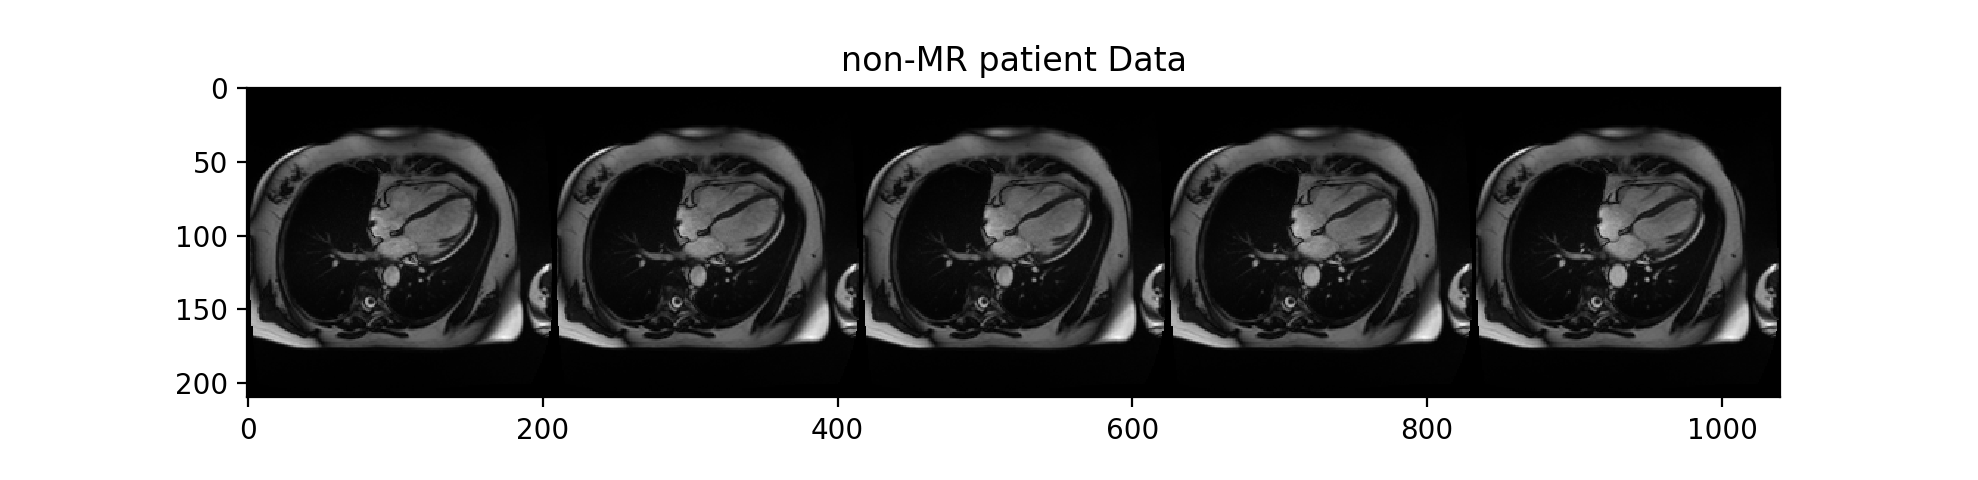

<IPython.core.display.Javascript object>


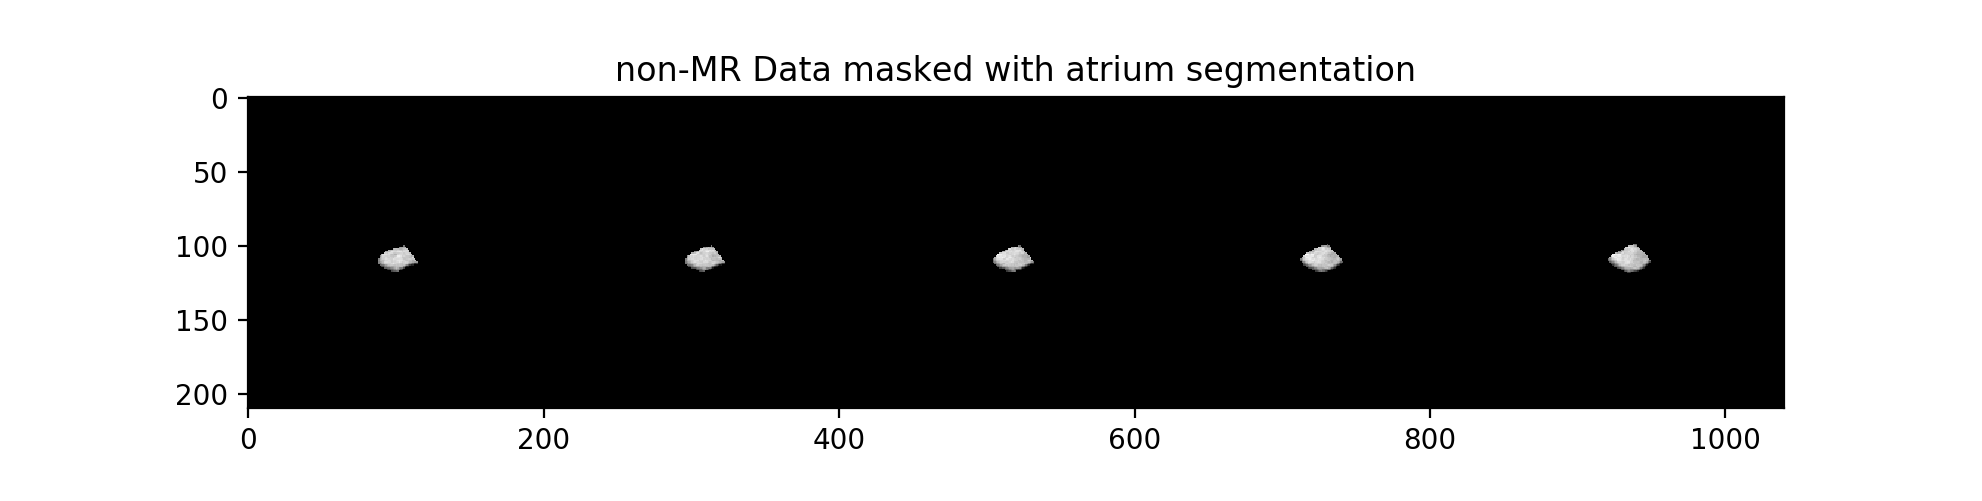

<IPython.core.display.Javascript object>


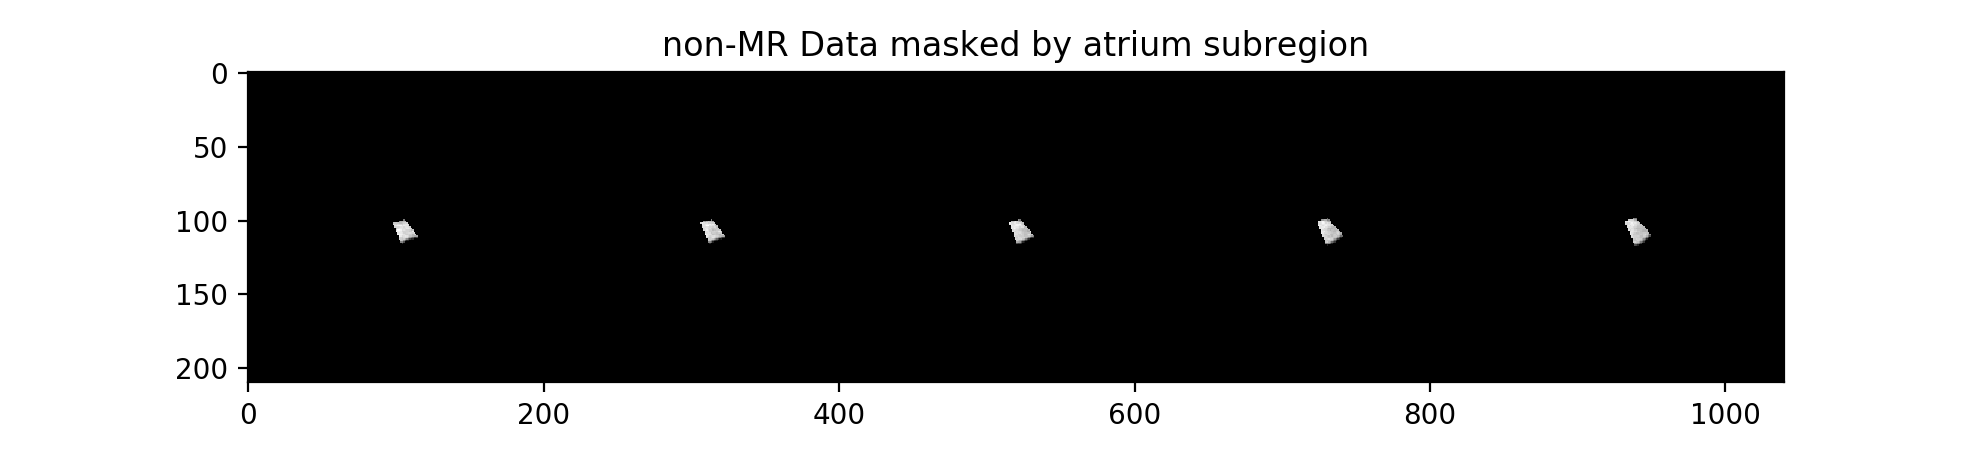

In [17]:
# narrowing down closed frames to 5
PID2 = nonMR_PIDs[0]
print(PID2)

num_frames = 5
frames = findClosedFrames(data[PID2], mask[PID2],num_frames)
data2 = data[PID2]
data2 = data2[frames,:,:]

plt.figure()
plt.title('non-MR patient Data')
plt.imshow(np.transpose(np.concatenate(data2, axis=0)), cmap = 'gray')

# plotting masked data
og_mask2 = mask[PID2]
og_mask2 = og_mask2[frames,:,:]
og_mask2[og_mask2!=1.0] = 0.0
og_masked_data2 = np.multiply(data2,og_mask2)

plt.figure()
plt.title('non-MR Data masked with atrium segmentation')
plt.imshow(np.transpose(np.concatenate(og_masked_data2, axis=0)), cmap = 'gray')


# plotting the image of the subregion for the PIDs
mask2 = mask[PID2]
mask2 = mask2[frames,:,:]
subregion_mask2 = findSubregion(mask2)

subregion_masked_data2 = np.multiply(data2,subregion_mask2)

plt.figure()
plt.title('non-MR Data masked by atrium subregion')
plt.imshow(np.transpose(np.concatenate(subregion_masked_data2, axis=0)), cmap = 'gray')

<IPython.core.display.Javascript object>


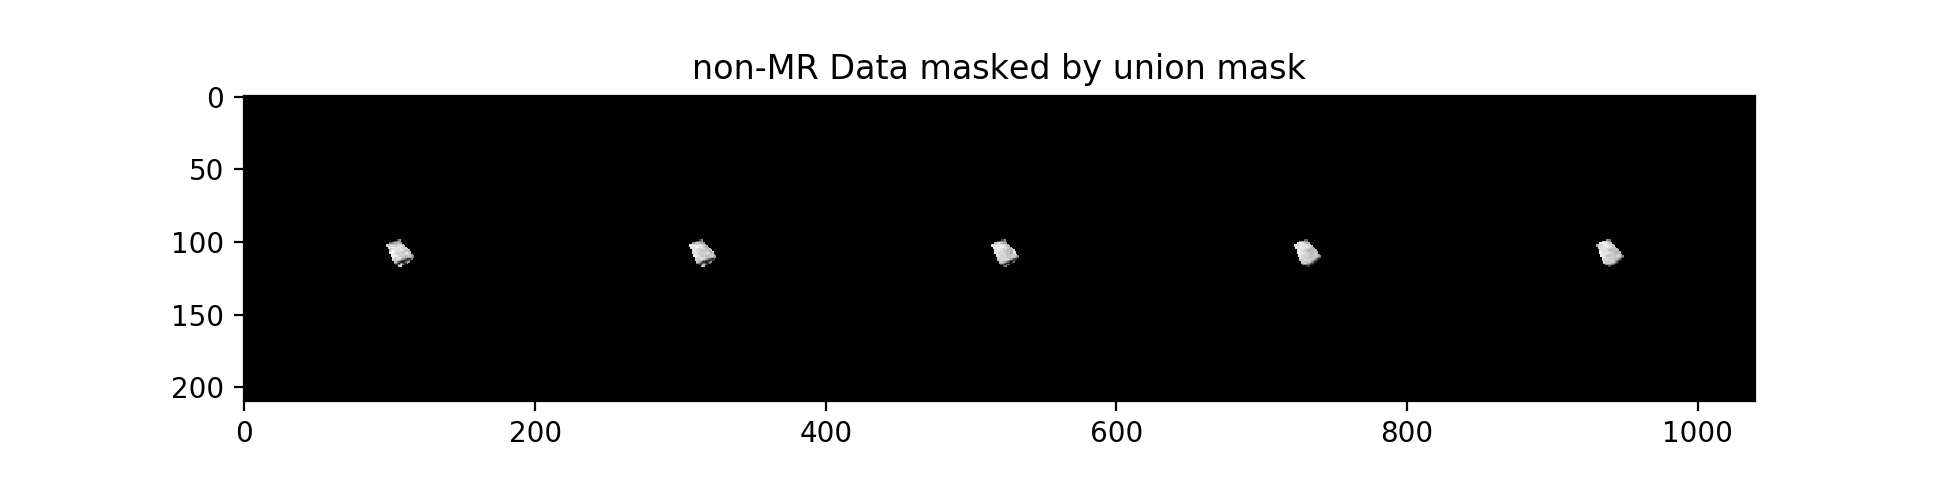

<IPython.core.display.Javascript object>


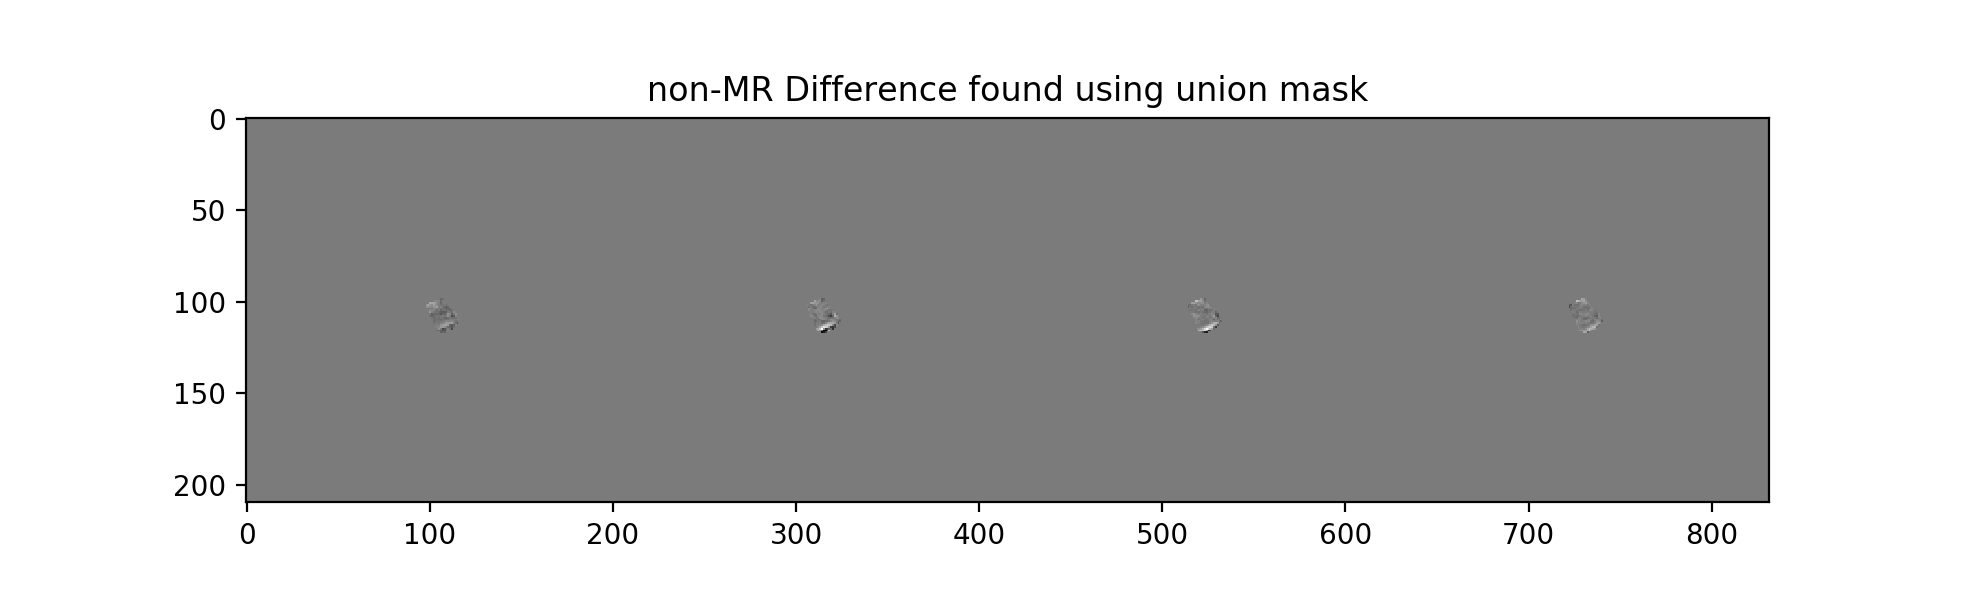

<IPython.core.display.Javascript object>


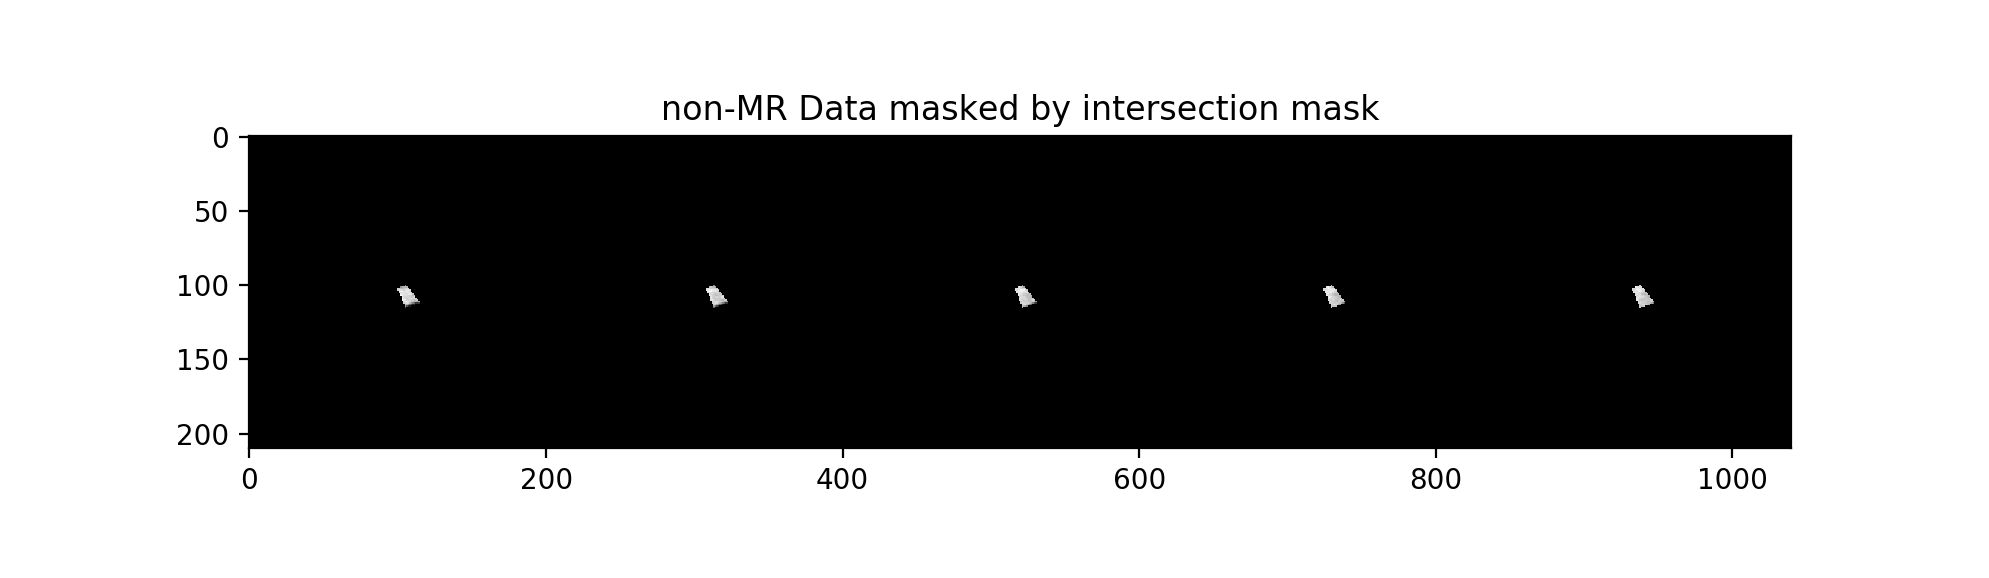

<IPython.core.display.Javascript object>


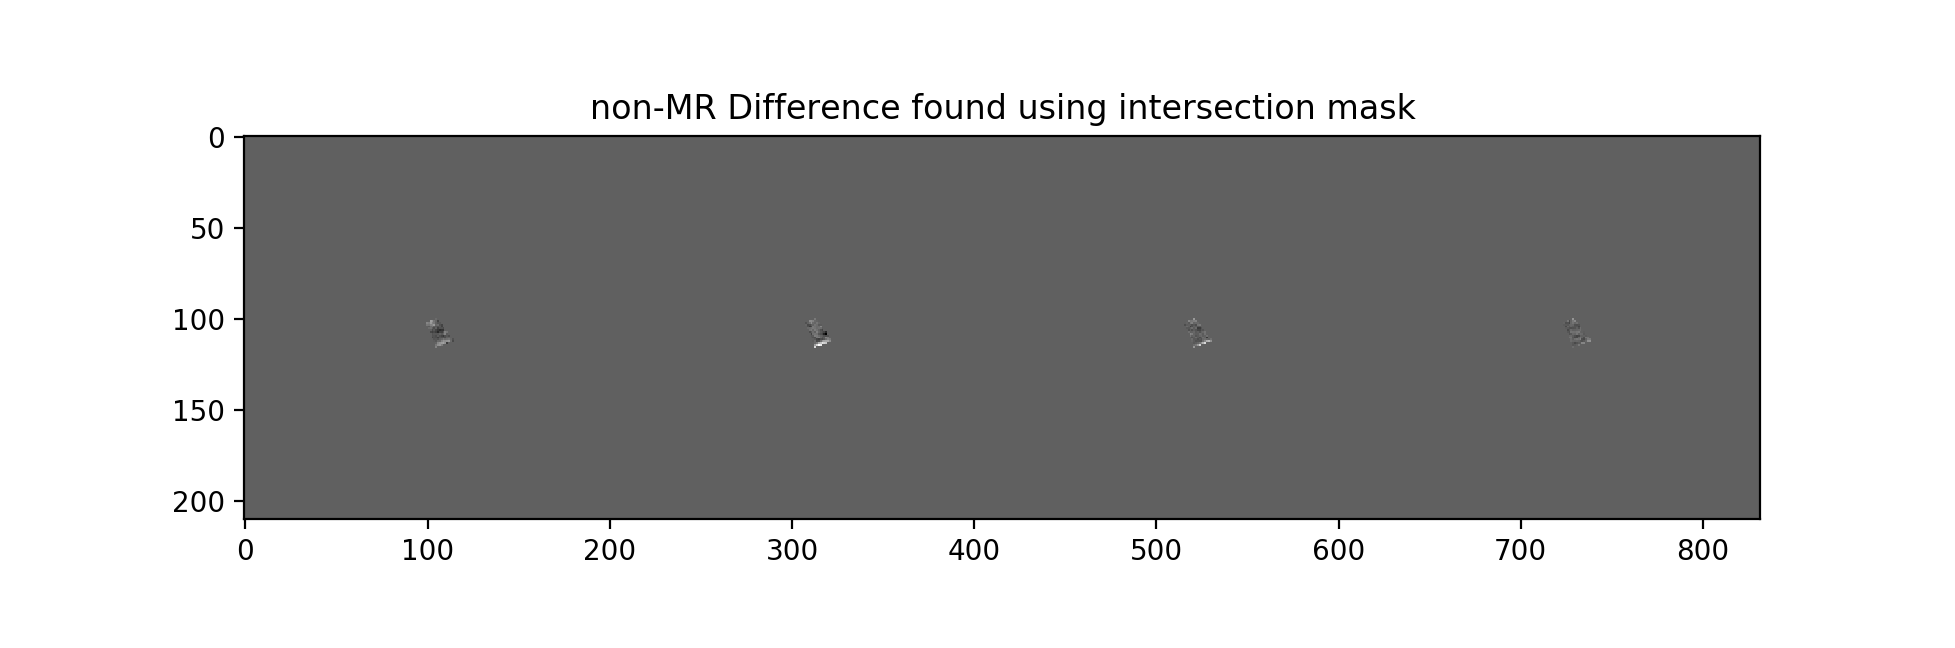

In [18]:
# subregion using union mask
union_mask2 = np.sum(subregion_mask2,axis=0)
union_mask2[union_mask2>1.0] = 1.0
union_mask2 = np.tile(union_mask2,(num_frames,1,1))
union_masked_data2 = np.multiply(data2,union_mask2)

plt.figure()
plt.title('non-MR Data masked by union mask')
plt.imshow(np.transpose(np.concatenate(union_masked_data2, axis=0)), cmap = 'gray')


# difference between frames in the subregion using union mask
union_difference_2 = union_masked_data2[1:,:,:] - union_masked_data2[0:-1,:,:]

plt.figure()
plt.title('non-MR Difference found using union mask')
plt.imshow(np.transpose(np.concatenate(union_difference_2, axis=0)), cmap = 'gray')


# subregion using an intersection mask
intersection_mask2 = np.prod(subregion_mask2,axis=0)
intersection_mask2 = np.tile(intersection_mask2,(num_frames,1,1))
intersection_masked_data2 = np.multiply(data2,intersection_mask2)

plt.figure()
plt.title('non-MR Data masked by intersection mask')
plt.imshow(np.transpose(np.concatenate(intersection_masked_data2, axis=0)), cmap = 'gray')

# difference between frames in the subregion using intersection mask
intersection_difference_2 = intersection_masked_data2[1:,:,:] - intersection_masked_data2[0:-1,:,:]

plt.figure()
plt.title('non-MR Difference found using intersection mask')
plt.imshow(np.transpose(np.concatenate(intersection_difference_2, axis=0)), cmap = 'gray')